<a href="https://colab.research.google.com/github/erikyryan/document-classification/blob/main/document_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Base de treinamento para a IA

## Import das funções

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import requests
import os
import zipfile
import glob
import cv2
import tensorflow as tf
import keras as K

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from random import randint
from sklearn import metrics
from sklearn.svm import SVC


In [2]:
def process_images(filepath, size, max_files=3500):
    filenames = []
    readed_imgs = []
    resized_imgs = []
    i = 0

    # Read file paths
    for filename in glob.glob(filepath):
        if ('segmentation' not in filename) and filename.endswith('.jpg') and i < max_files:
            filenames.append(filename)
            i += 1
        else:
            os.remove(filename)

    # Read images
    for img in filenames:
        readed_imgs.append(cv2.imread(img))

    # Resize images
    for img in readed_imgs:
        resized_imgs.append(cv2.resize(img, size))

    return resized_imgs

def started_values(x_values: list,y_values: list):
	x_values = np.concatenate(x_values,axis=0)
	y_values = np.array(y_values)
	y_values = y_values.reshape(-1)
	x_values = x_values.reshape(len(y_values),-1)

	return x_values,y_values

def result(test):
	if test == 1 or test == 2 or test == 3:
		return 'CNH'
	elif test == 4 or test == 5:
		return 'CPF'
	elif test == 7 or test == 6 or test == 8:
		return 'RG'
	else: return None

## Download e Extração das imagens de treinamento

In [3]:
pathSample = 'https://drive.google.com/uc?id=144EqqmMtCziua9iYo-3afUEvZrJVxUXU&export=download&confirm=t&uuid=363cbdc1-ef8d-40e3-ac8f-92e8efbac4de&at=AKKF8vwO3Rerxp4Y4e7nvK22YqGB:1687737101639' #Database Sample
compressionSamplePath = '/content/storage/sample.zip'
sourcePath = '/content/storage'

if not(os.path.isdir(sourcePath)):
  os.mkdir('storage') #diretorio para armazenar os arquivos baixados.

In [4]:
response = requests.post(pathSample)

with open(compressionSamplePath, 'wb') as file:
    file.write(response.content)

with zipfile.ZipFile(compressionSamplePath, 'r') as zip_ref:
    zip_ref.extractall(sourcePath)


Formatação dos CNH

In [5]:
cnh_aberta =  process_images(sourcePath +'/BID Sample Dataset/CNH_Aberta/*', (256,256))

cnh_frente =  process_images(sourcePath +'/BID Sample Dataset/CNH_Frente/*', (256,256))

cnh_verso =  process_images(sourcePath +'/BID Sample Dataset/CNH_Verso/*', (256,256))


Formatação dos CPFs

In [6]:
cpf_frente =  process_images(sourcePath +'/BID Sample Dataset/CPF_Frente/*', (256,256))

cpf_verso =  process_images(sourcePath +'/BID Sample Dataset/CPF_Verso/*', (256,256))

Foramtação dos documentos RG

In [7]:
rg_frente =  process_images(sourcePath +'/BID Sample Dataset/RG_Frente/*', (256,256))

rg_verso =  process_images(sourcePath +'/BID Sample Dataset/RG_Verso/*', (256,256))

rg_aberto =  process_images(sourcePath +'/BID Sample Dataset/RG_Aberto/*', (256,256))

## Teste de plotagem
remover

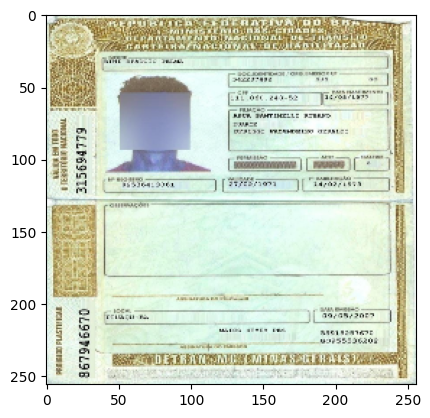

In [8]:
plt.imshow(cnh_aberta[3])
plt.show()

## Preparação dos dados para o treinamento

In [9]:
labels = [1,2,3,4,5,6,7,8]
documents = []

for a,b,c,d,e,f,g,h in zip(cnh_aberta,cnh_frente,cnh_verso,cpf_frente,cpf_verso,rg_frente,rg_verso,rg_aberto):
	documents.append({'x':a,'y':labels[0]})
	documents.append({'x':b,'y':labels[1]})
	documents.append({'x':c,'y':labels[2]})
	documents.append({'x':d,'y':labels[3]})
	documents.append({'x':e,'y':labels[4]})
	documents.append({'x':f,'y':labels[5]})
	documents.append({'x':g,'y':labels[6]})
	documents.append({'x':h,'y':labels[7]})


In [10]:
x_train = []
y_train = []

x_test = []
y_test = []

print(len(documents))

np.random.shuffle(documents)

x_train = [document['x'] for document in documents[:1000]]
y_train = [document['y'] for document in documents[:1000]]

x_test = np.array([document['x'] for document in documents[:2000]])
y_test = np.array([document['y'] for document in documents[:2000]])

272


In [11]:
x_train, y_train = started_values(x_train,y_train)
x_test, y_test = started_values(x_test,y_test)

# Modelo SVM

In [12]:
document_classifier = SVC(kernel='linear')
document_classifier.fit(x_train,y_train)

SVC(kernel='linear')

In [13]:
test = random.choice(documents[:1000]) #escolhendo de forma aleatória

prediction  = document_classifier.predict(test['x'].reshape(1,-1))

Document: CNH


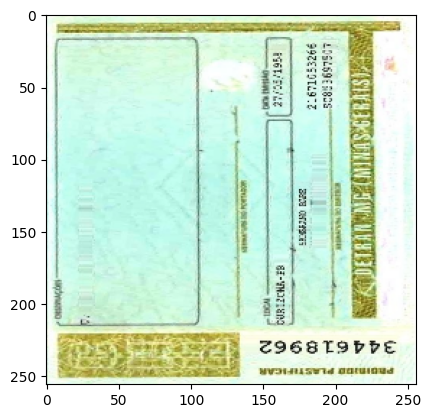

In [14]:
print('Document:', result(prediction))

plt.imshow(test['x'])
plt.show()

# Rede Neural Convolucional

In [15]:
x_train = x_train.reshape(len(x_train),256, 256, 3)
x_test = x_test.reshape(len(x_test), 256, 256, 3)

y_test = y_test.reshape(len(y_train), 1)
y_train = y_train.reshape(len(y_train), 1)

In [16]:
classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (256, 256, 3)))
classifier.add(MaxPooling2D((2,2)))

classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D((2,2)))

classifier.add(Flatten())
classifier.add(Dense(64,activation='relu'))
classifier.add(Dense(1,activation='sigmoid'))

In [17]:
classifier.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [18]:
classifier.fit(x_train, y_train, epochs=5, batch_size= 64)

Epoch 1/5
5/5 [==============================] - 27s 5s/step - loss: -91102.8438 - accuracy: 0.1250
Epoch 2/5
5/5 [==============================] - 21s 4s/step - loss: -856819.5625 - accuracy: 0.1250
Epoch 3/5
5/5 [==============================] - 23s 4s/step - loss: -3161258.2500 - accuracy: 0.1250
Epoch 4/5
5/5 [==============================] - 35s 7s/step - loss: -9185346.0000 - accuracy: 0.1250
Epoch 5/5
5/5 [==============================] - 21s 4s/step - loss: -22734826.0000 - accuracy: 0.1250


In [19]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 123008)            0         
                                                                 
 dense (Dense)               (None, 64)                7

# Treinando a Rede Neural Convolucional

In [20]:
test_loss, test_acc = classifier.evaluate(x_test, y_test)
print("Accuracy: ", test_acc)

9/9 [==============================] - 6s 605ms/step - loss: -36122944.0000 - accuracy: 0.1250
Accuracy:  0.125


In [21]:
from tensorflow.keras.utils import to_categorical

#classificação
classification = ['CNH','CNH','CNH','CPF','CPF','RG','RG','RG']

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [22]:
test_loss, test_acc = classifier.evaluate(x_test, y_test)
print("Accuracy: ", test_acc)

9/9 [==============================] - 7s 762ms/step - loss: -36122944.0000 - accuracy: 0.1250
Accuracy:  0.125


## Teste do modelo exemplo

In [ ]:
from google.colab import files
uploaded = files.upload()

#show the image
new_img = plt.imread('nome_da_imagem.jpg')
img = plt.imshow(new_img)

### Resize na imagem

In [ ]:
#resize image
from skimage.transform import resize
resized_image = resize(new_img,(64,64,3))
img = plt.imshow(resized_image)

## Predictions

In [ ]:
predictions = classifier.predict(np.array([resized_image])) #Get the models predictions

## Aplicação do modelo

In [ ]:
from types import prepare_class
#Sort the predictions from least to greatest
list_index = [1,2,3,4,5,6,7,8]
x = predictions

for i in range(8):
  for j in range(8):
    if x[0][list_index[i]] > x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp

#show the sorted labels order
print(list_index)

# Modelo de Acurácia

In [ ]:
#Vizualizacao do modelo de accuraria

#print('Accuracy:',metrics.accuracy_score(y_test[:1000],y_train[:1000]))

plt.plot(y_test[:1000])
plt.plot(y_train[:1000])
plt.title("Modelo de Acurácia:")
plt.ylabel('Acurácia')
plt.xlabel('Tempo')
plt.legend(['Treinamento', 'Valor'], loc='upper right')
plt.show()

## Modelo de accuracy

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy']) #validation accuracy
plt.title('Model accucary')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc='upper right')
plt.show()

## Modelo de loss

In [ ]:
#Vizualise the models loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss']) #validation loss
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc='upper right')
plt.show()

# Modelo de Perda

In [ ]:
#Vizulizacao do modelo de perda

plt.plot(y_test[:1000])
plt.plot(y_test[:1000])
plt.title("Modelo de Perda:")
plt.ylabel('Perda')
plt.xlabel('Tempo')
plt.legend(['Treinamento', 'Valor'], loc='upper left')
plt.show()

@inproceedings{sibgrapi_estendido,
 author = {Álysson Soares and Ricardo das Neves Junior and Byron Bezerra},
 title = {BID Dataset: a challenge dataset for document processing tasks},
 booktitle = {Anais Estendidos do XXXIII Conference on Graphics, Patterns and Images},
 location = {Evento Online},
 year = {2020},
 keywords = {},
 issn = {0000-0000},
 pages = {143--146},
 publisher = {SBC},
 address = {Porto Alegre, RS, Brasil},
 doi = {10.5753/sibgrapi.est.2020.12997},
 url = {https://sol.sbc.org.br/index.php/sibgrapi_estendido/article/view/12997}
}